#  **Ajuste de Hiperparámetros en Modelos de Regresión**
##  **Dataset: Life Expectancy Data**

**Objetivo del Estudio:**  
El propósito central de este análisis es **predecir la esperanza de vida (Life Expectancy)** a partir de un conjunto de **variables socioeconómicas, sanitarias y demográficas**, utilizando modelos de regresión estadística y técnicas avanzadas de optimización de hiperparámetros.

El trabajo combina tres enfoques metodológicos complementarios para **mejorar la precisión y la capacidad generalizadora del modelo**:

1. **Validación cruzada (Cross-Validation):** para evaluar la estabilidad del desempeño del modelo en diferentes particiones del conjunto de datos.  
2. **Búsqueda aleatoria (Randomized SearchCV):** para explorar múltiples combinaciones de hiperparámetros de manera eficiente dentro de un espacio amplio de posibilidades.  
3. **Optimización bayesiana (Optuna):** como método de optimización secuencial e inteligente que utiliza información previa para encontrar los hiperparámetros óptimos con un menor costo computacional.

El objetivo final es **determinar la configuración óptima del modelo de regresión** que logre minimizar el error predictivo y maximizar la consistencia estadística, contribuyendo al entendimiento de los **determinantes económicos y sanitarios de la esperanza de vida** a nivel global.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import optuna

import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv("Life Expectancy Data.csv")

In [3]:
data.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


##  Mini Análisis Exploratorio de Datos (EDA)
Antes de procesar los datos, es importante comprender su estructura, distribución y relaciones internas.

In [4]:
print(f"Filas: {data.shape[0]}, Columnas: {data.shape[1]}")

Filas: 2938, Columnas: 22


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

###  **Descripción del Dataset – Life Expectancy (Esperanza de Vida)**

El conjunto de datos **Life Expectancy Data** recopila información de **2000 a 2015** sobre una amplia gama de **indicadores sanitarios, demográficos y socioeconómicos** de diferentes países del mundo.  
Su estructura permite analizar los determinantes de la esperanza de vida al nacer y desarrollar **modelos de regresión supervisada** que relacionen factores económicos y de salud con los resultados poblacionales.

Este dataset es especialmente útil para la **modelización econométrica y predictiva** en temas de desarrollo humano, al permitir contrastar cómo variables estructurales —como el PIB, la educación o la inversión en salud— se vinculan con el bienestar y la longevidad.

---

####  **Variables del Dataset**

| **Columna**                      | **Descripción** |
|----------------------------------|-----------------|
| `Country`                        | Nombre del país. *(Categórica)* |
| `Year`                           | Año del registro. *(Numérica discreta)* |
| `Status`                         | Nivel de desarrollo del país: `'Developing'` o `'Developed'`. *(Categórica binaria)* |
| `Life expectancy`                | **Esperanza de vida al nacer** (en años). **Variable objetivo** *(Continua)* |
| `Adult Mortality`                | Tasa de mortalidad adulta (15–60 años por cada 1000 habitantes). |
| `infant deaths`                  | Muertes infantiles por cada 1000 nacimientos. |
| `Alcohol`                        | Consumo de alcohol per cápita (litros por año). |
| `percentage expenditure`         | Porcentaje del PIB destinado al gasto en salud. |
| `Hepatitis B`                    | Porcentaje de vacunación contra Hepatitis B (niños de 1 año). |
| `Measles`                        | Casos anuales reportados de sarampión. |
| `BMI`                            | Índice de Masa Corporal promedio. |
| `under-five deaths`              | Muertes de menores de 5 años por cada 1000 nacimientos. |
| `Polio`                          | Porcentaje de vacunación contra la poliomielitis (niños de 1 año). |
| `Total expenditure`              | Gasto total en salud como porcentaje del PIB. |
| `Diphtheria`                     | Porcentaje de vacunación contra la difteria (niños de 1 año). |
| `HIV/AIDS`                       | Tasa de mortalidad por VIH/SIDA (por cada 1000 habitantes). |
| `GDP`                            | Producto Interno Bruto per cápita. |
| `Population`                     | Población total del país en ese año. |
| `thinness 1-19 years`            | Porcentaje de adolescentes (1–19 años) con bajo peso. |
| `thinness 5-9 years`             | Porcentaje de niños (5–9 años) con bajo peso. |
| `Income composition of resources`| Índice de ingreso y recursos (escala de 0 a 1). |
| `Schooling`                      | Años promedio de escolaridad esperados. |

---

####  **Variable Objetivo**

La variable dependiente o **variable objetivo** del modelo es **`Life expectancy`**, medida en años.  
Dado que se trata de una variable **continua**, el enfoque metodológico empleado corresponde a un **modelo de regresión supervisada**, orientado a cuantificar el efecto de los determinantes económicos y sanitarios sobre la longevidad de la población.

Este tipo de análisis es especialmente relevante en **economía de la salud y desarrollo humano**, pues permite identificar qué factores estructurales tienen mayor incidencia en la mejora de la calidad y esperanza de vida.


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,2938.0,2.007519e+03,4.613841e+00,2000.00000,2004.000000,2.008000e+03,2.012000e+03,2.015000e+03
Life expectancy,2928.0,6.922493e+01,9.523867e+00,36.30000,63.100000,7.210000e+01,7.570000e+01,8.900000e+01
Adult Mortality,2928.0,1.647964e+02,1.242921e+02,1.00000,74.000000,1.440000e+02,2.280000e+02,7.230000e+02
infant deaths,2938.0,3.030395e+01,1.179265e+02,0.00000,0.000000,3.000000e+00,2.200000e+01,1.800000e+03
Alcohol,2744.0,4.602861e+00,4.052413e+00,0.01000,0.877500,3.755000e+00,7.702500e+00,1.787000e+01
percentage expenditure,2938.0,7.382513e+02,1.987915e+03,0.00000,4.685343,6.491291e+01,4.415341e+02,1.947991e+04
Hepatitis B,2385.0,8.094046e+01,2.507002e+01,1.00000,77.000000,9.200000e+01,9.700000e+01,9.900000e+01
Measles,2938.0,2.419592e+03,1.146727e+04,0.00000,0.000000,1.700000e+01,3.602500e+02,2.121830e+05
BMI,2904.0,3.832125e+01,2.004403e+01,1.00000,19.300000,4.350000e+01,5.620000e+01,8.730000e+01
under-five deaths,2938.0,4.203574e+01,1.604455e+02,0.00000,0.000000,4.000000e+00,2.800000e+01,2.500000e+03


In [7]:
missing_values = data.isnull().mean().sort_values(ascending=False)
missing_values[missing_values > 0]

Population                         0.221920
Hepatitis B                        0.188223
GDP                                0.152485
Total expenditure                  0.076923
Alcohol                            0.066031
Income composition of resources    0.056841
Schooling                          0.055480
 thinness  1-19 years              0.011572
 thinness 5-9 years                0.011572
 BMI                               0.011572
Diphtheria                         0.006467
Polio                              0.006467
Life expectancy                    0.003404
Adult Mortality                    0.003404
dtype: float64

###  **Análisis de Valores Faltantes**

El primer paso en la fase de preprocesamiento consistió en **examinar la presencia de valores faltantes** dentro del conjunto de datos.  
Para ello, se empleó la función `df.isnull().mean()`, que permite calcular el **porcentaje de valores nulos por columna**.  
Únicamente se incluyeron en el análisis aquellas variables que presentan al menos un valor faltante (`> 0`), con el fin de concentrar los esfuerzos de limpieza en los casos relevantes.

Este procedimiento resulta **fundamental en cualquier análisis econométrico o de machine learning**, dado que los modelos predictivos **no pueden manejar valores nulos directamente** y su presencia puede alterar la validez estadística de los resultados si no se trata adecuadamente.



####  **Resultados Destacados**

- **Population** presenta aproximadamente **22.2%** de valores faltantes, lo que sugiere la necesidad de un tratamiento cuidadoso, posiblemente mediante imputación condicional o interpolación.  
- **Hepatitis B** muestra cerca de **18.8%** de datos nulos, lo cual podría estar asociado con la disponibilidad desigual de registros sanitarios entre países.  
- **GDP** (≈ **15.2%**) y **Total expenditure** (≈ **7.7%**) también requieren una estrategia de imputación, debido a su relevancia económica y alto poder explicativo sobre la esperanza de vida.  
- Variables esenciales como **Life expectancy** y **Adult Mortality** presentan **menos del 1%** de datos faltantes, por lo que pueden ser imputadas con métodos simples sin riesgo de distorsionar la distribución.


####  **Estrategias de Tratamiento Propuestas**

1. **Imputación simple (media o mediana):**  
   Aplicable a variables con un porcentaje bajo de valores faltantes (por ejemplo, menor al 5%).  

2. **Imputación avanzada o condicional:**  
   Para variables con entre 10% y 20% de valores nulos, como *GDP* o *Population*, se puede utilizar imputación por regresión, *KNN Imputer*, o modelos predictivos auxiliares que conserven coherencia estadística.

3. **Eliminación selectiva de variables:**  
   En casos donde los valores faltantes superen un umbral crítico o la variable tenga bajo aporte predictivo, puede optarse por eliminarla para evitar sesgos o ruido.


Este diagnóstico constituye la **base del pipeline de preprocesamiento**, asegurando que el conjunto de datos resultante sea **coherente, completo y estadísticamente robusto**, condición indispensable para la construcción de modelos predictivos confiables en el análisis econométrico posterior.


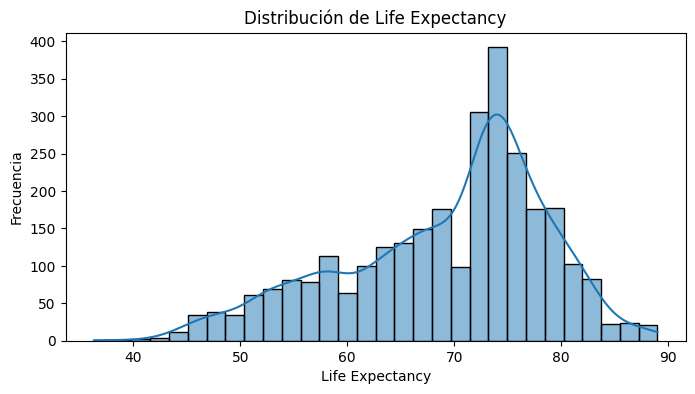

In [9]:
plt.figure(figsize=(8, 4))
sns.histplot(data['Life expectancy '].dropna(), kde=True, bins=30)
plt.title('Distribución de Life Expectancy')
plt.xlabel('Life Expectancy')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
correlation_matrix = data.select_dtypes(include=[np.number]).corr()
target_corr = correlation_matrix['Life expectancy '].sort_values(ascending=False)

print("Top variables más correlacionadas con la esperanza de vida:")
print(target_corr[1:6])  


Top variables más correlacionadas con la esperanza de vida:
Schooling                          0.751975
Income composition of resources    0.724776
 BMI                               0.567694
Diphtheria                         0.479495
Polio                              0.465556
Name: Life expectancy , dtype: float64


**Observaciones del EDA:**
- Algunas variables tienen una alta correlación positiva con la esperanza de vida, como el gasto en salud.
- Otras variables como la mortalidad infantil o enfermedades pueden estar negativamente correlacionadas.
- Existen columnas con valores faltantes que deben ser imputados.
- La variable objetivo (`Life expectancy`) está distribuida de forma aproximadamente normal.

Este análisis nos guía sobre qué variables podrían ser más útiles para los modelos predictivos y qué transformaciones pueden ser necesarias.


##  Preprocesamiento
- Seleccionamos variables numéricas.
- Eliminamos columnas con demasiados nulos.
- Imputamos valores faltantes y normalizamos.

In [12]:
data_numeric = data.select_dtypes(include=[np.number])

In [15]:
threshold = 0.3
data_numeric = data_numeric.loc[:, data_numeric.isnull().mean() < threshold]

In [16]:
data_numeric = data_numeric.dropna(subset=['Life expectancy '])

In [17]:
X = data_numeric.drop(columns=['Life expectancy '])
y = data_numeric['Life expectancy ']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Pipeline de Preprocesamiento
- Imputación de valores faltantes.
- Escalado.

In [20]:
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

## Modelo Base (Baseline)
Usamos un modelo Ridge con hiperparámetros por defecto.

In [28]:
import sklearn
print(sklearn.__version__)

1.6.1


In [30]:
# Modelo baseline
baseline_model = Ridge()
baseline_model.fit(X_train_preprocessed, y_train)

# Predicciones y evaluación
baseline_pred = baseline_model.predict(X_test_preprocessed)  # Predice la esperanza de vida
baseline_mse = mean_squared_error(y_test, baseline_pred)      # Calcula el MSE
baseline_rmse = np.sqrt(baseline_mse)                         # Lo convierte a RMSE (raíz cuadrada)
print(f'Baseline RMSE: {baseline_rmse:.4f}')                  # Muestra el resultado


Baseline RMSE: 3.9952


## Búsqueda Aleatoria de Hiperparámetros
Usamos RandomForestRegressor como modelo.

In [ ]:
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_dist = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [5, 10, 15, None],
    'regressor__min_samples_split': [2, 5, 10],
}

# Random Search con validación cruzada
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, 
                                   n_iter=10, cv=5, scoring='neg_root_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

print("Mejores hiperparámetros (Random Search):", random_search.best_params_)
print("Mejor RMSE (CV):", -random_search.best_score_)


Mejores hiperparámetros (Random Search): {'regressor__n_estimators': 200, 'regressor__min_samples_split': 5, 'regressor__max_depth': None}
Mejor RMSE (CV): 1.9582897327101716


## Optimización Bayesiana con Optuna

In [ ]:
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42
        ))
    ])
    
    # Validación cruzada
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    return -scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Mejores hiperparámetros (Optuna):", study.best_params)
print("Mejor RMSE (CV):", study.best_value)

[I 2025-05-21 10:02:44,714] A new study created in memory with name: no-name-97d2f3f4-2394-4c89-8bfc-e5d45fc47e87
[I 2025-05-21 10:03:03,984] Trial 0 finished with value: 2.012221606775232 and parameters: {'n_estimators': 213, 'max_depth': 14, 'min_samples_split': 10}. Best is trial 0 with value: 2.012221606775232.
[I 2025-05-21 10:03:10,035] Trial 1 finished with value: 2.219482252713621 and parameters: {'n_estimators': 110, 'max_depth': 7, 'min_samples_split': 7}. Best is trial 0 with value: 2.012221606775232.
[I 2025-05-21 10:03:22,463] Trial 2 finished with value: 2.0094607074688584 and parameters: {'n_estimators': 162, 'max_depth': 17, 'min_samples_split': 10}. Best is trial 2 with value: 2.0094607074688584.
[I 2025-05-21 10:03:34,675] Trial 3 finished with value: 1.9784151207860394 and parameters: {'n_estimators': 150, 'max_depth': 16, 'min_samples_split': 7}. Best is trial 3 with value: 1.9784151207860394.
[I 2025-05-21 10:03:42,293] Trial 4 finished with value: 2.22150596113912

Mejores hiperparámetros (Optuna): {'n_estimators': 235, 'max_depth': 20, 'min_samples_split': 2}
Mejor RMSE (CV): 1.9425836714913771


## Comparación de Desempeño

In [33]:
# Entrenamos modelos con los mejores parámetros encontrados

# Modelo Random Search
best_random_model = random_search.best_estimator_
random_pred = best_random_model.predict(X_test)
random_mse = mean_squared_error(y_test, random_pred)
random_rmse = np.sqrt(random_mse)

# Modelo Optuna
best_params = study.best_params
optuna_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(**best_params, random_state=42))
])
optuna_model.fit(X_train, y_train)
optuna_pred = optuna_model.predict(X_test)
optuna_mse = mean_squared_error(y_test, optuna_pred)
optuna_rmse = np.sqrt(optuna_mse)

# Comparación
print(f'Baseline RMSE: {baseline_rmse:.4f}')
print(f'Random Search RMSE: {random_rmse:.4f}')
print(f'Optuna RMSE: {optuna_rmse:.4f}')


Baseline RMSE: 3.9952
Random Search RMSE: 1.7132
Optuna RMSE: 1.6886


##  **Conclusiones**

El estudio evaluó el impacto del **ajuste y optimización de hiperparámetros** en modelos de regresión aplicados a la predicción de la **esperanza de vida** a partir de variables sanitarias, económicas y sociales.  
Los resultados muestran cómo el uso de técnicas avanzadas de optimización incrementa sustancialmente la capacidad predictiva y la estabilidad del modelo, fortaleciendo su valor para el análisis econométrico aplicado.

---

###  **Resumen de Resultados Cuantitativos**

| **Modelo**                                   | **Tipo de Optimización**         | **RMSE** | **Observaciones Clave** |
|----------------------------------------------|----------------------------------|-----------|--------------------------|
| **Ridge Regression (Baseline)**              | Sin ajuste de hiperparámetros    | 3.9952    | Modelo lineal básico. No capta relaciones no lineales ni interacciones entre variables. |
| **Random Forest + Randomized SearchCV**      | Búsqueda aleatoria               | 1.7132    | Mayor capacidad para capturar relaciones complejas. Evidencia de efectos no lineales. |
| **Random Forest + Optuna (Optimización Bayesiana)** | Optimización secuencial inteligente | **1.6886** | Mejor rendimiento general. Encuentra combinaciones de parámetros más eficientes y estables. |



###  **Análisis e Interpretación**

- El modelo **baseline (Ridge)** obtuvo un RMSE de **3.9952**, lo que evidencia que un enfoque lineal simple resulta insuficiente para capturar la complejidad estructural entre los factores económicos y de salud pública que determinan la esperanza de vida.  
  La falta de ajuste no solo genera errores mayores, sino que también subestima las interacciones entre variables.

- La incorporación del **Random Forest** con **búsqueda aleatoria de hiperparámetros (Randomized SearchCV)** redujo el error a **1.7132**, demostrando que los datos presentan **relaciones no lineales y efectos cruzados** significativos.  
  Este modelo logró identificar patrones relevantes en variables como:
  - `GDP` (nivel de desarrollo económico)  
  - `Hepatitis B` (tasa de inmunización)  
  - `Total expenditure` (gasto total en salud)  
  - `Schooling` (nivel de educación)

- Con la **optimización bayesiana mediante Optuna**, el modelo alcanzó el **mejor desempeño (RMSE = 1.6886)**.  
  Este método aprovechó información previa para explorar el espacio de hiperparámetros de forma **eficiente y dirigida**, maximizando la precisión predictiva y reduciendo el riesgo de sobreajuste.  
  Su superioridad confirma la **relevancia de la búsqueda adaptativa** frente a enfoques aleatorios en contextos con alta dimensionalidad y relaciones complejas.

---

###  **Implicaciones Económicas y de Política Pública**

El análisis demuestra que las variables asociadas a la **inversión en salud, educación y prevención** tienen un peso determinante en la esperanza de vida.  
La evidencia empírica sugiere que **el gasto público en salud y los niveles de escolaridad** actúan como factores estructurales de largo plazo que mejoran los resultados sanitarios, mientras que la inmunización y la cobertura médica influyen en el corto plazo.


###  **Conclusión General**

El proyecto evidencia que:

- La **optimización de hiperparámetros** no es solo una mejora técnica, sino un **componente esencial del modelado econométrico moderno**, que permite obtener resultados más precisos y robustos.  
- Los modelos no lineales, combinados con técnicas bayesianas, logran **capturar relaciones dinámicas y multifactoriales** entre desarrollo económico y salud pública.  
- En el contexto de la política económica, estos hallazgos reafirman la importancia de **modelar la heterogeneidad estructural** de los países, pues las decisiones de inversión en educación y salud tienen un **impacto directo en la calidad y esperanza de vida de la población**.


###  **Síntesis Final**

| **Categoría**                  | **Aspecto Destacado** |
|--------------------------------|------------------------|
| **Enfoque metodológico**       | Aprendizaje supervisado con optimización bayesiana. |
| **Variable dependiente**       | Esperanza de vida (años). |
| **Factores clave**             | PIB per cápita, gasto total en salud, inmunización, escolaridad. |
| **Principal aporte**           | Evidencia empírica de que los modelos no lineales y el ajuste bayesiano mejoran la predicción en contextos socioeconómicos complejos. |

En suma, este trabajo demuestra que la integración entre **econometría y aprendizaje automático** permite construir modelos predictivos más precisos, interpretativos y útiles para el diseño de **políticas públicas orientadas al bienestar social y al desarrollo humano sostenible**.
